<a href="https://colab.research.google.com/github/rickiepark/fine-tuning-llm/blob/main/Chapter5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 5장 `SFTTrainer`로 미세 튜닝 하기


### 스포일러

- 훈련 중에 메모리 부족 오류를 피하기 어려운 이유를 이해합니다.
- GPU RAM을 최대한 활용할 수 있는 설정을 알아 봅니다.
- `trl` 패키지의 `SFTTrainer` 클래스를 사용해 모델을 미세 튜닝합니다.
- (플래시 어텐션 2와 파이토치의 SDPA 같은) 메모리 효율적인 어텐션 구현의 장점을 논의합니다.

### 패키지 설치

훈련 재현성을 위해 이 책에서 사용하는 다음 버전과 동일 버전을 사용하세요.

In [1]:
!pip install transformers==4.56.1 peft==0.17.0 accelerate==1.10.0 trl==0.23.1 bitsandbytes==0.47.0 datasets==4.0.0 huggingface-hub==0.34.4 safetensors==0.6.2 pandas==2.2.2 matplotlib==3.10.0 numpy==2.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 113.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.9/503.9 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.7/374.7 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.6/564.6 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 41.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.35.3
    Uninstalling huggingface-hub-0.35.3:
      Successfully uninstalled huggingface-hub-0.35.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.1
    Uninstalling transformers-4.57.1:
      Successfully uninstalled transformers-4.57.1
  Attempting uninstall: accelerate
    Found existing installation:

### 라이브러리 임포트

In [2]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset, Dataset
from peft import get_peft_model, prepare_model_for_kbit_training, LoraConfig, \
    AutoPeftModelForCausalLM
from transformers import Trainer, TrainingArguments, AutoTokenizer, \
    AutoModelForCausalLM, BitsAndBytesConfig
from trl import SFTTrainer, SFTConfig, setup_chat_format

In [3]:
# 깃허브에서 compatibility_functions.py 파일과 compatibility_functions.py 파일을 다운로드합니다.
!wget https://raw.githubusercontent.com/rickiepark/fine-tuning-llm/refs/heads/main/helper_functions.py
!wget https://raw.githubusercontent.com/rickiepark/fine-tuning-llm/refs/heads/main/compatibility_functions.py

from helper_functions import *
from compatibility_functions import DataCollatorForCompletionOnlyLM

--2025-10-25 05:42:34--  https://raw.githubusercontent.com/rickiepark/fine-tuning-llm/refs/heads/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6492 (6.3K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   6.34K  --.-KB/s    in 0s      

2025-10-25 05:42:35 (118 MB/s) - ‘helper_functions.py’ saved [6492/6492]

--2025-10-25 05:42:35--  https://raw.githubusercontent.com/rickiepark/fine-tuning-llm/refs/heads/main/compatibility_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting re

### 목표

활성화 계산을 위한 공간이 남아 있는 한 베이스 모델, 어댑터, 옵티마이저, 미니 배치를 최대한 GPU RAM에 밀어 넣습니다. 메모리 확보를 위해 계산을 희생하고(그레이디언트 체크포인팅), 파라미터 업데이트를 지연하고(그레이디언트 누적), 메모리 효율적인 어텐션 메커니즘 구현(플래시 어텐션이나 파이토치의 SDPA)을 사용합니다.

### 준비 운동

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/forward_pass.png?raw=True)
<center>그림 5.1 정방향 계산</center>

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/backward_pass.png?raw=True)
<center>그림 5.2 역방향 계산</center>

### 훈련 과정 핵심 정리

$$
\Large
\text{memory}_{\text{total}} = \underbrace{\text{memory}_{\text{model}}}_{\text{stage}_0} +
\underbrace{\text{memory}_{\text{batch}} + \text{memory}_{\text{act}}}_{\text{stage}_1} + \underbrace{\text{memory}_{\text{grad}}}_{\text{stage}_2} + \underbrace{\text{memory}_{\text{optim}}}_{\text{stage}_3}
$$

<center>식 5.1 모델 훈련에 사용되는 총 메모리</center>

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/gpu_ram-no_lora.png?raw=True)
<center>그림 5.3 가중치, 그레이디언트, 옵티마이저에서 사용되는 메모리 </center>

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/gpu_ram-8bit_adam.png?raw=True)
<center>그림 5.4 가중치, 그레이디언트, 옵티마이저에서 사용되는 메모리 </center>

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/gpu_ram-lora.png?raw=True)
<center>그림 5.5 LoRA의 메모리 사용량</center>

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/gpu_ram-lora_s.png?raw=True)
<center>그림 5.6 활성화 메모리 사용량</center>


![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/gpu_ram-lora_short_s.png?raw=True)
<center>Figure 5.5 - Taking activations into account (shorter sequences)</center>

$$
\Large
\frac{\text{memory}_{\text{act}}^{\text{eager attn}}}{\text{memory}_{\text{model}}} = \left[3\frac{s}{h} + \frac{1}{2}n_{\text{heads}}\left(\frac{s}{h}\right)^2\right]\frac{p_{\text{comp}}}{p_{\text{model}}}
$$

<center>식 5.2 활성화와 모델의 메모리 사용 비율</center>

****
**인기 모델의 구성**

| 모델 | hidden_dim (h)  | max seq (s) | n_heads (n_h)  | n_layers (L) |
|---|---|---|---|---|
| OPT-350M  | 1024  | 2048  | 16  | 24  |
| Phi-3.5 Mini  | 3072  | 4096  | 32  | 32  |
| Llama-2 7B  | 4096  | 4096  | 32  | 32  |
| Llama-3.2 3B  | 3072  | 8192  | 24  | 28  |
| Mistral 8B  | 4096  | 32768  | 32  | 32  |
| Qwen-2.5 7B  | 3584  | 32768  | 28  | 28  |
| OLMo 7B  | 4096  | 2048  | 32  | 32   |
****

$$
\Large
\begin{aligned}
\frac{\text{memory}_{\text{act}}^{\text{eager attn}}}{18} &= \left[3\frac{500}{2048} + \frac{1}{2}16\left(\frac{500}{2048}\right)^2\right]\frac{16}{8}
\\
&= \left[\frac{3}{4}+\frac{1}{2}\right]2 = \frac{3}{2} + 1
\\
\text{memory}_{\text{act}}^{\text{eager attn}} &= 18\frac{3}{2} + 18 = 27 + 18 = 45
\end{aligned}
$$
<center>식 5.3 활성화와 모델의 메모리 사용 비율 계산</center>

$$
\Large
\frac{\text{memory}_{\text{act}}^{\text{flash attn}}}{\text{memory}_{\text{model}}} = 3\frac{s}{h}\frac{p_{\text{comp}}}{p_{\text{model}}}
$$
<center>식 5.4 효율적인 어텐션 구현에서 활성화와 모델의 메모리 사용 비율</center>

$$
\Large
\text{batch_size}_{\text{effective}} = \text{batch_size}_{\text{micro}} * \text{n_accumulation_steps}
$$
<center>식 5.5 유효 미니 배치 크기</center>

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/training_loop.png?raw=True)
<center>그림 5.8 메모리 절약 기법과 훈련 루프의 단계</center>

$$
\Large
\text{memory}_{\text{total}} = \underbrace{\text{memory}_{\text{model}}}_{\text{quantization}} +
\underbrace{\text{memory}_{\text{batch}}}_{\text{grad acc}} + \underbrace{\text{memory}_{\text{act}}}_{\text{grad checkp \ flash attn}} + \underbrace{\text{memory}_{\text{grad}} + \text{memory}_{\text{optim}}}_{\text{LoRA \ 8-bit paged optim \ grad acc}}
$$
<center>식 5.6 메모리 절약 기법과 적용 대상</center>

****
**활성화 메모리 공식**

이 사이드바에서 메모리 할당 공식이 어떻게 만들어졌는지 설명하겠습니다. 이 공식은 Korthikanti 등이 쓴 ["Reducing Activation Recomputation in Large Transformer Models"](https://arxiv.org/abs/2205.05198) 논문을 기반으로 합니다.

은닉 크기 $h$(모델의 차원), $L$ 개의 층(트랜스포머 블록), $n_\text{heads}$ 개의 어텐션 헤드를 가진 일반적인 트랜스포머 모델의 경우, 모델의 총 파라미터 개수와 시퀀스 길이 $s$인 미니 배치 $b$에서 계산되는 활성화 총 크기는 다음과 같습니다.

$$
\Large
\begin{align}
\text{memory}_{\text{model}} = &L 12 h^2
\\
\text{memory}_{\text{act}} = &L \left( \alpha h b s + \beta n_{\text{heads}} b s^2 \right)
\end{align}
$$
<center>식 5.7 일반적인 트랜스포머를 위한 공식</center>

공식 끝에 시퀀스 길이의 제곱이 보이나요? 즉시 모드 어텐션의 높은 비용이 여기서 드러납니다.

[QUESTION]
"_알파(𝛼)와 베타(𝛽)는 무언가요..._"

좋은 지적입니다! 즉시 모드 어텐션을 사용하는 평범한 트랜스포머의 경우 알파와 베타는 각각 34와 5입니다. 하지만 핵심은 플래시 어텐션(또는 SDPA)을 사용하는 경우 베타는 0이 됩니다! 더이상 시퀀스 길이를 제곱하지 않아도 됩니다!

$$
\Large
\begin{align}
\text{memory}_{\text{act}}^{\text{eager attn}} \underset{\alpha=34\\\beta=5}{=} &L \left( 34 h b s + 5 n_{\text{heads}} b s^2 \right)
\\
\text{memory}_{\text{act}}^{\text{flash attn}} \underset{\alpha=34\\\beta=0}{=} &L \left( 34 h b s \right)
\end{align}
$$
<center>식 5.8 즉시 모드 어텐션과 플래시 어텐션을 위한 공식</center>

위 두 공식을 사용하여 활성화를 위해 할당된 메모리와 모델 자체에서 점유한 메모리 간의 비율을 계산할 수 있습니다. 이 경우 계산에 사용된 데이터 타입(`p_comp`)와 모델 가중치에 사용된 데이터 타입(`p_model`)을 고려해야 합니다.

$$
\Large
\begin{align}
\frac{\text{memory}_{\text{act}}^{\text{eager attn}}}{\text{memory}_{\text{model}}} &= \left[\frac{34bs}{12h} + \frac{5n_{\text{heads}}bs^2}{12h^2}\right]\frac{p_{\text{comp}}}{p_{\text{model}}}
\\
&\underset{b=1}{\approx} \left[3\frac{s}{h} + \frac{1}{2}n_{\text{heads}}\left(\frac{s}{h}\right)^2\right]\frac{p_{\text{comp}}}{p_{\text{model}}}
\end{align}
$$

$$
\Large
\begin{align}
\frac{\text{memory}_{\text{act}}^{\text{flash attn}}}{\text{memory}_{\text{model}}} &= \frac{34bs}{12h}\frac{p_{\text{comp}}}{p_{\text{model}}}  \underset{b=1}{\approx} 3\frac{s}{h}\frac{p_{\text{comp}}}{p_{\text{model}}}
\end{align}
$$
<center>식 5.9 즉시 모드 어텐션과 플래시 어텐션의 메모리 사용량 비율</center>

자, 결과가 나왔습니다! 단순화를 위해 미니 배치 크기를 1로 가정하고 분수를 반올림하면 앞에서 소개한 것과 동일한 공식을 얻게 됩니다.
****

### 준비 코드

In [4]:
supported = torch.cuda.is_bf16_supported(including_emulation=False)
compute_dtype = (torch.bfloat16 if supported else torch.float32)

nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=compute_dtype
)

model_q4 = AutoModelForCausalLM.from_pretrained("facebook/opt-350m",
                                                device_map='cuda:0',
                                                quantization_config=nf4_config)

model_q4 = prepare_model_for_kbit_training(model_q4)

config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)
peft_model = get_peft_model(model_q4, config)

tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")
tokenizer = modify_tokenizer(tokenizer)
tokenizer = add_template(tokenizer)

peft_model = modify_model(peft_model, tokenizer)

dataset = load_dataset("dvgodoy/yoda_sentences", split="train")
dataset = dataset.rename_column("sentence", "prompt")
dataset = dataset.rename_column("translation_extra", "completion")

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/663M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/662M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/531 [00:00<?, ?B/s]

sentences.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/720 [00:00<?, ? examples/s]

***

**중요**: 안타깝게도 최근 버전의 trl 라이브러리는 (prompt와 completion 열을 필요로 하는) 지시 포맷을 더이상 지원하지 않습니다. 이로 인해 채팅 템플릿이 올바르게 적용되지 않습니다. 이 문제를 피하기 위해 대화 포맷을 사용하는 것이 좋습니다.
***

In [5]:
# trl.extras.dataset_formatting.instructions_formatting_function을 참고함.
# 데이터셋을 (더이상 지원되지 않는) prompt/completion 포맷에서 대화 포맷으로 변경합니다.
def format_dataset(examples):
    if isinstance(examples["prompt"], list):
        output_texts = []
        for i in range(len(examples["prompt"])):
            converted_sample = [
                {"role": "user", "content": examples["prompt"][i]},
                {"role": "assistant", "content": examples["completion"][i]},
            ]
            output_texts.append(converted_sample)
        return {'messages': output_texts}
    else:
        converted_sample = [
            {"role": "user", "content": examples["prompt"]},
            {"role": "assistant", "content": examples["completion"]},
        ]
        return {'messages': converted_sample}

dataset = dataset.map(format_dataset)
dataset = dataset.remove_columns(['prompt', 'completion', 'translation'])

Map:   0%|          | 0/720 [00:00<?, ? examples/s]

### `SFTTrainer`로 미세 튜닝하기

****
**`SFTTrainer`로 미세 튜닝하기" 요약**
- 다음 훈련 클래스 객체는 데이터셋이 지원하는 포맷 중 하나인 기본적인 경우에 해당합니다.
  - 프롬프트와 완성 모두에 대해서 훈련
    ```python
    supported = torch.cuda.is_bf16_supported(including_emulation=False)
    trainer = SFTTrainer(
        model=model,
        processing_class=tokenizer,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset
        peft_config=peft_config,
        data_collator=None,
        args=SFTConfig(
            output_dir="./future_name_on_the_hub",
            packing=True,
            packing_strategy='wrapped',
            max_length=max_seq_length,
            bf16=supported
        )
    )
    ```
  - 완성에서만 훈련
    ```python
    supported = torch.cuda.is_bf16_supported(including_emulation=False)
    tokenizer.padding_side='left'
    response_template = '...' # according to the tokenizer's chat template
    collator_fn=DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

    trainer = SFTTrainer(
        model=model,
        processing_class=tokenizer,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        peft_config=peft_config,
        data_collator=collator_fn,
        args=SFTConfig(
            output_dir="./future_name_on_the_hub",
            packing=False,
            max_seq_length=max_seq_length,
            bf16=supported
        )
    )
    ```
- 훈련 클래스를 통해 모델에 LoRA를 적용하면 자동으로 `get_peft_model()`와 `prepare_model_for_kbit_training()`를 호출합니다.
  - `model` 매개변수는 베이스 모델을 받아야 합니다(양자화된 모델도 가능하지만 직접 `get_peft_model()` 함수를 호출해서는 안됩니다).
  - `peft_config`는 `LoraConfig`의 인스턴스를 받아야 합니다.
- 데이터셋이 지원하는 포맷 중 하나가 아닌 경우 `formatting_func` 매개변수를 사용해 사용자 정의 포맷팅 함수를 지정합니다(4장의 BYOFF).
- 훈련 클래스의 인스턴스를 만든 후 미니 배치를 추출하여 콜레이터가 적절하게 설정되어 있고 레이블이 예상대로인지 확인합니다.
    ```python
    dataloader = trainer.get_train_dataloader()
    batch = next(iter(dataloader))
    labels = batch['labels'][0]
    valid = labels >= 0
    print(tokenizer.decode(labels[valid]))
    ```
****

In [6]:
mvt_trainer = SFTTrainer(
    model=peft_model,
    processing_class=tokenizer,
    train_dataset=dataset,
    args=SFTConfig(
        output_dir="./future_model_name_on_the_hub",
        report_to='none'
    )
)

Tokenizing train dataset:   0%|          | 0/720 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/720 [00:00<?, ? examples/s]

#### 데이터 로더 다시 확인하기

In [7]:
mvt_train_dataloader = mvt_trainer.get_train_dataloader()
batch = next(iter(mvt_train_dataloader))
batch['input_ids'][:2]

tensor([[50265, 12105, 50118,  1213,   362,    49,  1159,    31,     5,   285,
           334,     4,     2, 50118, 50265,  2401, 33388, 50118,  7605,     5,
           285,   334,     6,    49,  1159,    51,   362,     4,   289,   338,
         41311,     4,     2, 50118,     1,     1,     1,     1,     1,     1,
             1,     1],
        [50265, 12105, 50118,   250,  9371,    16,    99, 33199,   460,  1733,
            11,     4,     2, 50118, 50265,  2401, 33388, 50118,  2264, 33199,
           460,  1733,    11,     6,    10,  9371,    16,     4,   854, 47820,
          7485,    29,     4,     2, 50118,     1,     1,     1,     1,     1,
             1,     1]], device='cuda:0')

In [8]:
tokenizer.pad_token_id, tokenizer.padding_side

(1, 'right')

패딩 토큰은 왼쪽에 있어야 합니다. 생성 언어 모델을 훈련할 때 오른쪽 패딩은 사용해서는 안됩니다.

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch4/packing_flow.png?raw=True)

<center>그림 5.9 올바른 데이터 설정 선택하기</center>

In [9]:
pack_trainer = SFTTrainer(
    model=peft_model,
    processing_class=tokenizer,
    train_dataset=dataset,
    data_collator=None,
    args=SFTConfig(
        output_dir="./future_name_on_the_hub",
        packing=True,
        packing_strategy='wrapped',
        max_length=64,
        report_to='none',
        bf16=supported
    )
)

Packing train dataset:   0%|          | 0/720 [00:00<?, ? examples/s]

In [10]:
pack_train_dataloader = pack_trainer.get_train_dataloader()
batch = next(iter(pack_train_dataloader))
batch['input_ids'][:2]

tensor([[50265, 12105, 50118,   133,  4716,  1536,  1136,    19,     5,   220,
         32322,     9,  2508,     4,     2, 50118, 50265,  2401, 33388, 50118,
          3908,     5,   220, 32322,     9,  2508,     6,     5,  4716,  1536,
          1136,     4,  3216,     6,  1368, 28015, 41311,     4,     2, 50118,
         50265, 12105, 50118, 34306,   110,   275, 35310,     7,     5,   371,
          1380,     4,     2, 50118, 50265,  2401, 33388, 50118,  3972,     5,
           371,  1380,     6,   836],
        [12105, 50118, 29729,   661,     5,  7511,     7,   110,   314,  4793,
             4,     2, 50118, 50265,  2401, 33388, 50118, 29729,   661,     5,
          7511,     7,   110,   314,  4793,     6,    47,   531,     4,     2,
         50118, 50265, 12105, 50118, 21031,     5, 20058,  2718,     7,  1338,
             5,  8037,     4,     2, 50118, 50265,  2401, 33388, 50118,  3972,
          1338,     5,  8037,     6,   185,     5, 20058,  2718,     6,    47,
           531

In [11]:
tokenizer.padding_side='left'

response_template = '<|im_start|>assistant\n'
collator_fn=DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

completions_trainer = SFTTrainer(
    model=peft_model,
    processing_class=tokenizer,
    train_dataset=dataset,
    data_collator=collator_fn,
    args=SFTConfig(
        output_dir="./future_name_on_the_hub",
        packing=False,
        max_length=64,
        report_to='none',
        bf16=supported
    )
)

Tokenizing train dataset:   0%|          | 0/720 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/720 [00:00<?, ? examples/s]

In [12]:
completions_train_dataloader = completions_trainer.get_train_dataloader()
batch = next(iter(completions_train_dataloader))
input_ids = batch['input_ids'][0]
labels = batch['labels'][0]
input_ids, labels

(tensor([    1,     1,     1,     1,     1,     1,     1,     1, 50265, 12105,
         50118,  1213,   362,    49,  1159,    31,     5,   285,   334,     4,
             2, 50118, 50265,  2401, 33388, 50118,  7605,     5,   285,   334,
             6,    49,  1159,    51,   362,     4,   289,   338, 41311,     4,
             2, 50118], device='cuda:0'),
 tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  7605,     5,   285,   334,
             6,    49,  1159,    51,   362,     4,   289,   338, 41311,     4,
             2, 50118], device='cuda:0'))

In [13]:
print(tokenizer.decode(input_ids))

<pad><pad><pad><pad><pad><pad><pad><pad><|im_start|>user
They took their kids from the public school.</s>
<|im_start|>assistant
From the public school, their kids they took. Hrmmm.</s>



In [14]:
valid = labels >= 0
print(tokenizer.decode(labels[valid]))

From the public school, their kids they took. Hrmmm.</s>



#### 실제 훈련

****
**중요**: 이 글을 쓰는 시점에 `trl` 버전(0.21)은 LoRA 설정이 모델에 이미 적용되어 있을 때 훈련이 실패하는 문제가 있습니다. 이는 훈련 객체가 어댑터를 포함하여 모델 전체를 동결하기 때문입니다.

이 예제에서처럼 모델이 어댑터를 포함하고 있다면 원본 모델(`model.base_model.model`)과 `peft_config` 매개변수를 함께 사용해야 훈련이 됩니다.

이 문제는 2025년 10월 릴리스된 `trl` 0.23.1 버전에서 수정되었습니다.
****

In [15]:
trainer = SFTTrainer(
    model=peft_model,
    processing_class=tokenizer,
    train_dataset=dataset,
    data_collator=None,
    args=SFTConfig(
        output_dir="./future_name_on_the_hub",
        packing=True,
        packing_strategy='wrapped',
        max_length=64,
        report_to='none',
        bf16=supported
    )
)

Tokenizing train dataset:   0%|          | 0/720 [00:00<?, ? examples/s]

Packing train dataset:   0%|          | 0/720 [00:00<?, ? examples/s]

In [16]:
trainer.train()

Step,Training Loss
10,5.305600
20,4.988000
30,4.595300
40,4.270700
50,4.044600
60,3.815300
70,3.719700
80,3.578000
90,3.488200
100,3.452800


TrainOutput(global_step=144, training_loss=3.887978302107917, metrics={'train_runtime': 39.8222, 'train_samples_per_second': 28.929, 'train_steps_per_second': 3.616, 'total_flos': 134891635212288.0, 'train_loss': 3.887978302107917, 'entropy': 3.443879246711731, 'num_tokens': 73695.0, 'mean_token_accuracy': 0.4444444477558136, 'epoch': 3.0})

In [17]:
print(generate(trainer.model, tokenizer, "There is bacon in this sandwich."))

<|im_start|>user
There is bacon in this sandwich.</s>
<|im_start|>assistant

<|im_start|>assistant

<|im_start|>assistant

<|im_start|>assistant

<|im_start|>assistant

<|im_start|>assistant

<|im_start|>assistant

<|im_start|>assistant

<|im_start|>assistant

<|im_start|>assistant

<|im_start|>assistant

<|im_start|>assistant

<|im_start|>assistant

<|im_start|>assistant


In [18]:
trainer.args.learning_rate, trainer.args.per_device_train_batch_size, trainer.args.num_train_epochs

(2e-05, 8, 3.0)

In [19]:
trainer.optimizer.__class__

accelerate.optimizer.AcceleratedOptimizer

In [20]:
trainer.optimizer.optimizer.__class__

torch.optim.adamw.AdamW

***
**단순화한 훈련 루프**

```python
n_epochs = trainer.args.num_train_epochs
# 패킹과 콜레이터 설정에 따라 데이터 로더를 가져옵니다.
train_dataloader = trainer.get_train_dataloader()
# 단계 0
trainer.create_optimizer()
# `args`에 전달된 모든 객체를 분산 훈련과 혼합 정밀도를 위해 준비하고
# 동일한 순서대로 반환합니다.
trainer.model, trainer.optimizer = trainer.accelerator.prepare(
	trainer.model, trainer.optimizer
)
# 필요하면 그레이디언트 체크포인팅을 활성화합니다.
if trainer.args.gradient_checkpointing:
    trainer.model.gradient_checkpointing_enable(
    	gradient_checkpointing_kwargs={'use_reentrant': False}
    )
trainer.model.zero_grad()

for epoch in range(int(n_epochs)):
    for step, inputs in enumerate(train_dataloader):
        # 그레이디언트 누적을 준비합니다.
        with trainer.accelerator.accumulate(trainer.model):
            trainer.model.train()
            # 단계 1
            ## 재귀적으로 리스트/튜플/딕셔너리를 순회하면서
            ## 모든 텐서를 trainer.args.device에 전송합니다.
            inputs = trainer._prepare_inputs(inputs)
            ## 정방향 계산
            outputs = trainer.model(**inputs)
            ## 마이크로 배치 손실을 추출합니다.
            loss = (outputs["loss"] if isinstance(outputs, dict) else outputs[0])
            # 단계 2
            ## 역방향 계산 - 역전파
            trainer.accelerator.backward(loss)
            
        # 단계 3
        ## 파라미터 업데이트
        trainer.optimizer.step()
        # 단계 4
        ## 그레이디언트 재설정
        trainer.model.zero_grad()
```
***

### `SFTConfig`

****
**"`SFTConfig` 요약"**
- 다음과 같은 기본 설정이 좋은 출발점입니다.
    ```python
    supported = torch.cuda.is_bf16_supported(including_emulation=False)
    lr = ...
    num_train_epochs = ...
    min_effective_batch_size = 8
    max_seq_length = ...
    collator_fn = ...
    packing = (collator_fn is None)
    steps = 50

    sft_config = SFTConfig(
        output_dir='./future_name_on_the_hub',
        # 데이터셋
        packing=packing,
        packing_strategy='wrapped',
        max_length=max_seq_length,
        # 그레이디언트 / 메모리
        gradient_checkpointing=True,
        gradient_checkpointing_kwargs={'use_reentrant': False},
        gradient_accumulation_steps=2,
        per_device_train_batch_size=min_effective_batch_size,
        auto_find_batch_size=True,
        # 훈련
        num_train_epochs=num_train_epochs,
        learning_rate=lr,
        # 환경 및 로깅
        report_to='tensorboard',
        logging_dir='./logs',
        logging_strategy='steps',
        logging_steps=steps,
        evaluation_strategy='steps',
        evaluation_steps=steps,
        save_strategy='steps',
        save_steps=steps,
        bf16=supported
    )
    ```
- 혼합 정밀도 훈련(속도 향상을 위해 추가적인 메모리 사용량이 약간 늘어날 수 있습니다)의 경우 다음 매개변수를 포함합니다.
    ```python
        fp16: not torch.cuda.is_bf16_supported(),
        bf16: torch.cuda.is_bf16_supported(),
    ```
****

#### 메모리 관련 매개변수

In [21]:
def find_max_batch_size(trainer, initial_batch_size=None, update_trainer=False):
    from copy import deepcopy
    from accelerate.utils import find_executable_batch_size as accelerate_find_executable_batch_size

    # 동일 모델을 사용해 새로운 더미 Trainer 객체를 만듭니다.
    new_trainer = SFTTrainer(
        model=trainer.model
    )
    # 저수준에서 전체 설정을 복제합니다.
    new_trainer.__dict__.update(**trainer.__dict__)
    # SFTConfig을 수정하기 때문에 deepcopy로 복사합니다.
    new_trainer.args = deepcopy(new_trainer.args)
    # 학습률을 0으로 설정하므로 모델이 업데이트되지 않습니다.
    new_trainer.args.learning_rate = 0
    # OOM만 확인하면 되므로 1스텝만 실행합니다.
    new_trainer.args.max_steps = 1

    # 이 함수를 사용한다면 실제 Trainer에 이를 지정할 필요가 없습니다.
    new_trainer.args.auto_find_batch_size = True
    # 시작점으로 원본 `per_device_train_batch_size`를 사용하지만 바꿀 수 있습니다.
    if initial_batch_size is not None:
        new_trainer.args.per_device_train_batch_size = initial_batch_size

    # 내부적으로 일어나는 일은 다음과 같습니다.
    # 내부 훈련 루프를 기반으로 데코레이트된 함수를 만듭니다.
    func = accelerate_find_executable_batch_size(new_trainer._inner_training_loop)
    # 그다음 복사된 매개변수로 훈련 루프를 실행합니다.
    # 예외가 일어날 때마다 배치 크기를 절반으로 줄입니다.
    # 성공할 때까지 이를 반복하여 시도합니다.
    # lr=0이므로 모델이 변경되지 않습니다.
    func(args=new_trainer.args)
    # `_train_batch_size` 속성에 성공한 배치 크기가 있습니다.
    max_batch_size = new_trainer._train_batch_size
    del new_trainer

    # 편의상 배치 크기를 직접 업데이트할 수 있습니다.
    if update_trainer:
        trainer.args.per_device_train_batch_size = max_batch_size

    return max_batch_size

#### 혼합 정밀도 매개변수

```python
def peft_module_casting_to_bf16(model):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.LayerNorm) or "norm" in name:
            module = module.to(torch.float32)
        elif any(x in name for x in ["lm_head", "embed_tokens", "wte", "wpe"]):
            if hasattr(module, "weight"):
                if module.weight.dtype == torch.float32:
                    module = module.to(torch.bfloat16)
```

### (진짜!) 실제 훈련

In [22]:
supported = torch.cuda.is_bf16_supported(including_emulation=False)
min_effective_batch_size = 8
lr = 3e-4
max_seq_length = 64
collator_fn = None
packing = (collator_fn is None)
steps = 20
num_train_epochs = 10

sft_config = SFTConfig(
    output_dir='./future_name_on_the_hub',
    # 데이터셋
    packing=packing,
    packing_strategy='wrapped',
    max_length=max_seq_length,
    # 그레이디언트 / 메모리
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={'use_reentrant': False},
    gradient_accumulation_steps=2,
    per_device_train_batch_size=min_effective_batch_size,
    auto_find_batch_size=True,
    # 훈련
    num_train_epochs=num_train_epochs,
    learning_rate=lr,
    # 환경 및 로깅
    report_to='tensorboard',
    logging_dir='./logs',
    logging_strategy='steps',
    logging_steps=steps,
    save_strategy='steps',
    save_steps=steps,
    bf16=supported
)

trainer = SFTTrainer(
    model=peft_model,
    processing_class=tokenizer,
    train_dataset=dataset,
    data_collator=collator_fn,
    args=sft_config
)
trainer.train()

Step,Training Loss
20,2.588400
40,2.118500
60,1.925900
80,1.842500
100,1.770800
120,1.732200
140,1.705100
160,1.675500
180,1.644600
200,1.644600


TrainOutput(global_step=240, training_loss=1.825031073888143, metrics={'train_runtime': 147.049, 'train_samples_per_second': 26.114, 'train_steps_per_second': 1.632, 'total_flos': 449638784040960.0, 'train_loss': 1.825031073888143, 'epoch': 10.0})

In [23]:
print(generate(trainer.model, tokenizer, "There is bacon in this sandwich."))

<|im_start|>user
There is bacon in this sandwich.</s>
<|im_start|>assistant
In this sandwich, bacon there is.</s>


#### 어댑터 저장

In [24]:
trainer.save_model('yoda-adapter')

In [25]:
os.listdir('yoda-adapter')

['adapter_config.json',
 'added_tokens.json',
 'chat_template.jinja',
 'merges.txt',
 'vocab.json',
 'README.md',
 'special_tokens_map.json',
 'adapter_model.safetensors',
 'tokenizer_config.json',
 'tokenizer.json',
 'training_args.bin']

#### 전체 모델 저장

In [26]:
reloaded_model = AutoPeftModelForCausalLM.from_pretrained('yoda-adapter')
reloaded_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): OPTForCausalLM(
      (model): OPTModel(
        (decoder): OPTDecoder(
          (embed_tokens): Embedding(50272, 512, padding_idx=1)
          (embed_positions): OPTLearnedPositionalEmbedding(2050, 1024)
          (project_out): Linear(in_features=1024, out_features=512, bias=False)
          (project_in): Linear(in_features=512, out_features=1024, bias=False)
          (layers): ModuleList(
            (0-23): 24 x OPTDecoderLayer(
              (self_attn): OPTAttention(
                (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
                (v_proj): lora.Linear(
                  (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1024, out_features=16, bias=False

In [27]:
merged_model = reloaded_model.merge_and_unload()
merged_model

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 512, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 1024)
      (project_out): Linear(in_features=1024, out_features=512, bias=False)
      (project_in): Linear(in_features=512, out_features=1024, bias=False)
      (layers): ModuleList(
        (0-23): 24 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=409

In [28]:
merged_model.save_pretrained('yoda-merged')

#### 허브에 푸시하기

In [29]:
from huggingface_hub import login
login()

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch0/hub0.png?raw=True)
<center>Figure 5.10 - Logging into the Hugging Face Hub</center>

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch0/hub1.png?raw=True)
<center>Figure 5.11- Successful Login</center>

In [30]:
trainer.push_to_hub()

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...n_the_hub/adapter_model.safetensors:   9%|8         |  561kB / 6.30MB            

  ...e_name_on_the_hub/training_args.bin:   9%|8         |   547B / 6.16kB            

CommitInfo(commit_url='https://huggingface.co/haesun/future_name_on_the_hub/commit/dfe6e4ad6863eed3110b3981e3d9964ea6b09e2d', commit_message='End of training', commit_description='', oid='dfe6e4ad6863eed3110b3981e3d9964ea6b09e2d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/haesun/future_name_on_the_hub', endpoint='https://huggingface.co', repo_type='model', repo_id='haesun/future_name_on_the_hub'), pr_revision=None, pr_num=None)

### 어텐션

$$
\Large
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$
<center>식 5.10 어텐션 공식</center>

****
**"어텐션" 절의 요약**
- 허깅 페이스에서 인기가 높은 트랜스포머 모델은 이미 메모리 효율적인 SDPA 구현을 지원하므로 `attn_implementation` 매개변수를 사용하여 쉽게 사용할 수 있습니다.
    ```python
    model = AutoModelForCausalLM.from_pretrained(repo_id, attn_implementation="sdpa")
    ```
- 플래시 어텐션 2는 SDPA에 비해 약간의 성능 향상을 제공할 수 있습니다. 하지만 기본적으로 16비트 데이터 타입(FP16과 BF16)만 지원한다는 제약이 뒤따릅니다.
  - `torch_dtype`을 적절히 지정하거나 (내부적으로 타입을 지정하는) 양자화된 모델을 로드해야 합니다.
    ```python
    model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m",
                                                 torch_dtype=torch.bfloat16,
                                                 attn_implementation="flash_attention_2")
    ```
    - 앞서 언급한 대로 완전한 FP16으로 모델을 훈련하면 언더플로나 오버플로가 일어날 수 있습니다.
    - 완전한 BF16으로 모델을 훈련하는 것에도 문제가 있으며 확률적 반올림을 구현한 옵티마이저를 사용해야 할 수 있습니다(자세한 내용은 "플래시 어텐션 2" 절의 "완전한 BF16 훈련" 사이드바를 참고하세요).
    - FP32를 선택한다면 혼합 정밀도 훈련을 사용해야 합니다(훈련 설정에서 `fp16`이나 `bf16` 매개변수 중 하나만 `True`로 설정합니다). 그렇지 않으면 런타임 오류가 발생합니다.
****


****
**스케일링 인자**
```python
import math
import torch
d_k = 1024
q_vector = torch.randn(1000, 1, d_k)
v_vector = torch.randn(1000, 1, d_k).permute(0, 2, 1)
torch.bmm(q_vector, v_vector).squeeze().std(), math.sqrt(d_k)
```
```
(tensor(32.5935), 32.0)
```
****

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/sdpa.png?raw=True)
<center>그림 5.12 어텐션 메커니즘</center>

$$
\Large
d_k = \frac{d_\text{model}}{n_{\text{heads}}}
$$
<center>식 5.11 어텐션 헤드의 차원</center>

In [31]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, n_heads, d_model, dropout=0.1, verbose=False):
        super(MultiHeadedAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = int(d_model / n_heads)
        self.linear_query = nn.Linear(d_model, d_model)
        self.linear_key = nn.Linear(d_model, d_model)
        self.linear_value = nn.Linear(d_model, d_model)
        self.linear_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(p=dropout)
        self.alphas = None
        self.verbose = verbose

    def print_sizes(self, name, tensor):
        if self.verbose:
            print(f'{name:<22} - 크기: {str(tensor.shape):<30}'
                  f'- 원소 개수: {str(torch.numel(tensor)):>10}')

    def make_chunks(self, x):
        batch_size, seq_len = x.size(0), x.size(1)
        # N, L, D -> N, L, n_heads * d_k
        x = x.view(batch_size, seq_len, self.n_heads, self.d_k)
        # N, n_heads, L, d_k
        x = x.transpose(1, 2)
        return x

    def init_keys(self, key):
        # N, n_heads, L, d_k
        self.proj_key = self.make_chunks(self.linear_key(key))
        self.proj_value = self.make_chunks(self.linear_value(key))

    def alignment_function(self, query):
        # 스케일드 점곱 어텐션
        # N, n_heads, L, d_k x # N, n_heads, d_k, L -> N, n_heads, L, L
        proj_query = self.make_chunks(self.linear_query(query))
        dot_products = torch.matmul(proj_query,
                                    self.proj_key.transpose(-2, -1))
        scores =  dot_products / np.sqrt(self.d_k)

        self.print_sizes('쿼리 투영', proj_query)
        self.print_sizes('키 투영', self.proj_key)
        self.print_sizes('값 투영', self.proj_value)
        self.print_sizes('점곱', dot_products)
        self.print_sizes('정렬', scores)
        return scores

    def attn(self, query, mask=None):
        # 쿼리는 배치 차원이 먼저 등장합니다: N, L, D
        # 정렬 함수는 각 헤드에 대한 정렬 결과를 계산합니다.
        alignments = self.alignment_function(query) # N, n_heads, L, L
        if mask is not None:
            alignments = alignments.masked_fill(mask == 0, -1e9)
        alphas = F.softmax(alignments, dim=-1) # N, n_heads, L, L
        alphas = self.dropout(alphas)
        self.alphas = alphas.detach()

        # N, n_heads, L, L x N, n_heads, L, d_k -> N, n_heads, L, d_k
        context = torch.matmul(alphas, self.proj_value)

        self.print_sizes('어텐션 가중치 / 알파', alphas)
        self.print_sizes('문맥 벡터 (헤드)', context)
        return context

    def output_function(self, contexts):
        # N, L, D
        out = self.linear_out(contexts) # N, L, D

        self.print_sizes('출력 문맥 벡터', out)
        return out

    def forward(self, query, mask=None):
        self.init_keys(query)

        if mask is not None:
            # N, 1, L, L - 모든 헤드가 동알한 마스크를 사용합니다.
            mask = mask.unsqueeze(1)

        # N, n_heads, L, d_k
        context = self.attn(query, mask=mask)
        # N, L, n_heads, d_k
        context = context.transpose(1, 2).contiguous()
        # N, L, n_heads * d_k = N, L, d_model
        context = context.view(query.size(0), -1, self.d_model)
        # N, L, d_model
        out = self.output_function(context)
        return out

In [32]:
bsize = 1      # N
seqlen = 256   # L
d_model = 1024 # D
n_heads = 16   # 헤드 개수
# d_k = D / n_heads = 64
input_batch = torch.randn(bsize, seqlen, d_model)

In [33]:
mha = MultiHeadedAttention(n_heads=n_heads, d_model=d_model, verbose=True)
out = mha(input_batch)

쿼리 투영                  - 크기: torch.Size([1, 16, 256, 64])  - 원소 개수:     262144
키 투영                   - 크기: torch.Size([1, 16, 256, 64])  - 원소 개수:     262144
값 투영                   - 크기: torch.Size([1, 16, 256, 64])  - 원소 개수:     262144
점곱                     - 크기: torch.Size([1, 16, 256, 256]) - 원소 개수:    1048576
정렬                     - 크기: torch.Size([1, 16, 256, 256]) - 원소 개수:    1048576
어텐션 가중치 / 알파           - 크기: torch.Size([1, 16, 256, 256]) - 원소 개수:    1048576
문맥 벡터 (헤드)             - 크기: torch.Size([1, 16, 256, 64])  - 원소 개수:     262144
출력 문맥 벡터               - 크기: torch.Size([1, 256, 1024])    - 원소 개수:     262144


![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/eager_attn.png?raw=True)

<center>그림 5.13 즉시 모드 어텐션의 메모리 연산</center>

#### 플래시 어텐션 2

[flash-attn 패키지](https://github.com/Dao-AILab/flash-attention)를 설치해야 합니다. 구식 GPU는 지원하지 않는다는 점을 유의하세요. 플래시 어텐션은 BF16 데이터 타입을 지원하는 암페어(Ampere), 에이다(Ada), 호퍼(Hopper) GPU에서만 동작합니다(예를 들어 A100, RTX 3090, RTX 4090, H100).

또한 이 패키지를 설치하려면 NVCC(NVIDIA CUDA Compiler)를 설치해야 합니다. 다음 명령으로 설치 여부를 간단히 확인할 수 있습니다.

```shell
nvcc --version
```

다음과 같은 출력이 나오면 모든 준비가 된 것입니다.

```
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Sep_12_02:18:05_PDT_2024
Cuda compilation tools, release 12.6, V12.6.77
Build cuda_12.6.r12.6/compiler.34841621_0
```

하지만 `nvcc`가 시스템에 없다면 [CUDA 툴킷](https://developer.nvidia.com/cuda-downloads)을 설치해야 할 수 있습니다.

다음 단계로 플래시 어텐션 패키지를 설치합니다.

```shell
pip install -U flash-attn
```

설치가 완료되면 `transformers`의 헬퍼 함수로 플래시 어텐션을 사용할 수 있는지 체크합니다.

```python
from transformers.utils import is_flash_attn_2_available

is_flash_attn_2_available()
```

```
True
```

플래시 어텐션은 FP16과 BF16을 포함해 16비트 데이터 타입만 지원합니다.

In [ ]:
# 다음 코드는 플래시 어텐션 2가 설치되고 환경에서 지원되는 경우에만 실행됩니다.
model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m",
                                             device_map='cuda:0',
                                             torch_dtype=torch.bfloat16,
                                             attn_implementation="flash_attention_2")

In [ ]:
# 다음 코드는 플래시 어텐션 2가 설치되고 환경에서 지원되는 경우에만 실행됩니다.
bnb_config = BitsAndBytesConfig(load_in_4bit=True)

model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m",
                                             device_map='cuda:0',
                                             quantization_config=bnb_config,
                                             attn_implementation="flash_attention_2")

기본적으로 이 메시지는 FP32를 사용할 수 있지만 혼합 정밀도로 모델을 훈련해야 합니다. 이를 위한 fp16과 bf16 설정에 대해 알고 있습니다.

In [ ]:
# 다음 코드는 플래시 어텐션 2가 설치되고 환경에서 지원되는 경우에만 실행됩니다.
model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m",
                                             device_map='cuda:0',
                                             torch_dtype=torch.float32,
                                             attn_implementation="flash_attention_2")

```python
sft_config = SFTConfig(
    ...
    # 혼합 정밀도
    fp16=not torch.cuda.is_bf16_supported(),
    bf16=torch.cuda.is_bf16_supported()
)
```

****
**완전한 BF16 훈련**

```python
# !pip install torchao
from torchao.prototype.low_bit_optim import _AdamW
optim = _AdamW(model_bf16.parameters(), bf16_stochastic_round=True)
```

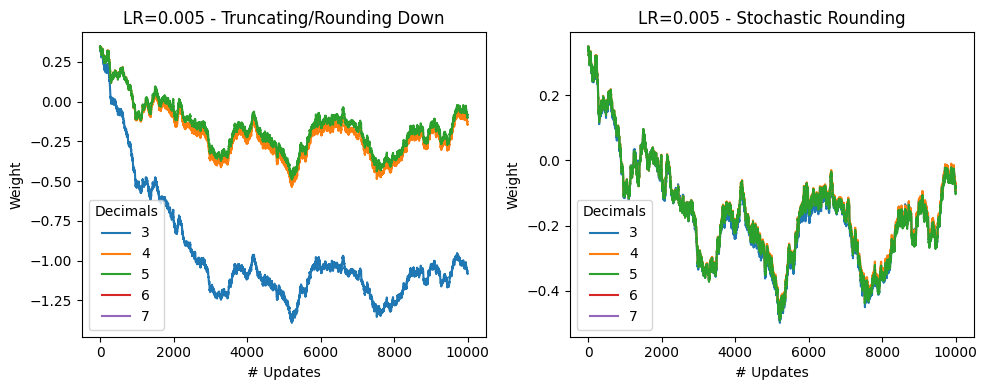

In [36]:
from matplotlib import pyplot as plt

lr = 5e-3
res = rounding_evolution(n_updates=10000, decimals=7, lr=lr)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(np.array(list(res[False].values())).T)
axs[0].legend(res[False].keys(), title='Decimals')
axs[0].set_title(f'LR={lr} - Truncating/Rounding Down')
axs[0].set_ylabel('Weight')
axs[0].set_xlabel('# Updates')
axs[1].plot(np.array(list(res[True].values())).T)
axs[1].legend(res[True].keys(), title='Decimals')
axs[1].set_title(f'LR={lr} - Stochastic Rounding')
axs[1].set_ylabel('Weight')
axs[1].set_xlabel('# Updates')
fig.tight_layout()

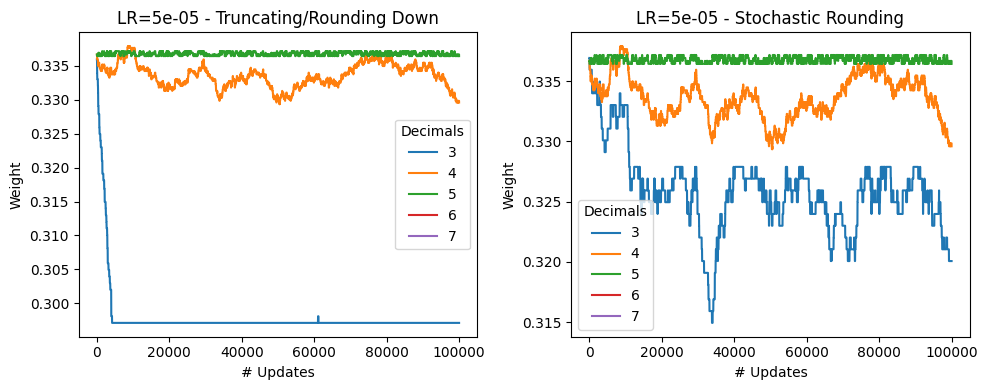

In [37]:
lr = 5e-5
res = rounding_evolution(n_updates=100000, decimals=7, lr=lr)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(np.array(list(res[False].values())).T)
axs[0].legend(res[False].keys(), title='Decimals')
axs[0].set_title(f'LR={lr} - Truncating/Rounding Down')
axs[0].set_ylabel('Weight')
axs[0].set_xlabel('# Updates')
axs[1].plot(np.array(list(res[True].values())).T)
axs[1].legend(res[True].keys(), title='Decimals')
axs[1].set_title(f'LR={lr} - Stochastic Rounding')
axs[1].set_ylabel('Weight')
axs[1].set_xlabel('# Updates')
fig.tight_layout()

#### 파이토치의 SDPA

In [38]:
model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m",
                                             device_map='cuda:0',
                                             attn_implementation="sdpa")

#### 결론

In [39]:
# https://colab.research.google.com/drive/1_zuAiiBFoFWpexxeWsTS694tCSlMYydo를 참고함
def benchmark(model, inputs, n_iterations):
    torch.cuda.reset_max_memory_allocated(device)
    torch.cuda.reset_peak_memory_stats(device)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    start_event.record()

    for _ in range(n_iterations):
        _ = model(inputs)

    end_event.record()
    torch.cuda.synchronize()

    max_memory = torch.cuda.max_memory_allocated(device)

    return start_event.elapsed_time(end_event) / n_iterations, max_memory

벤치마크를 실행할 때마다 깨끗한 상태에서 시작하기 위해 커널을 재시작해야 합니다.

In [40]:
repo_id = 'facebook/opt-350m'
device = torch.device("cuda:0")
attn_implementation = ['eager', 'sdpa', 'flash_attention_2']
# 다른 구현을 사용하려면 이 값을 바꾸세요.
i = 0 # 즉시 모드 어텐션
# 어텐션 메커니즘만 GPU에 로드하면 되므로 모델을 CPU에 로드합니다.
model = AutoModelForCausalLM.from_pretrained(repo_id, device_map='cpu',
                                     torch_dtype=torch.float16,
                                     attn_implementation=attn_implementation[i])
# 첫 번째 층에 있는 어텐션 메커니즘
attn = model.model.decoder.layers[0].self_attn
attn

OPTAttention(
  (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
  (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
  (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
  (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
)

In [41]:
batch_size = 2
sequence_length = 1024
shape = (batch_size, sequence_length, model.config.hidden_size)
inputs = torch.randn(shape, device=device).half()

# 워밍업
attn.to(device)
_ = attn(inputs)

In [42]:
benchmark(attn, inputs, 1000)

/usr/local/lib/python3.12/dist-packages/torch/cuda/memory.py:491: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


(0.8858112182617187, 778033664)

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/attn_comparison.png?raw=True)
<center>Table 5.1 - Comparing the performance of attention’s implementations</center>

### 실험 결과, 어블레이션 스타일

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/mem_16_seq500.png?raw=True)

<center>표 5.2 16비트 OPT-350M과 시퀀스 길이 500에서 최대 메모리 사용량</center>

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/mem_16_seq2k.png?raw=True)

<center>표 5.3 16비트 OPT-350M과 시퀀스 길이 2,000에서 최대 메모리 사용량</center>

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/mem_8_opt.png?raw=True)

<center>표 5.4 양자화된 OPT-350M의 최대 메모리 사용량</center>

![](https://github.com/dvgodoy/FineTuningLLMs/blob/main/images/ch5/mem_8_falcon.png?raw=True)
<center>표 5.5 양자화된 팔콘 7B의 최대 메모리 사용량</center>

### 다음 장에서는

계산과 메모리를 교환하는 것은 성공적인 LLM 미세 튜닝으로 이어지는 핵심 요소 중 하나입니다. 이를 통해 LLM이 대화하는 방법과 입력 받은 모든 토큰에 효율적으로 주의를 기울이는 방법을 학습합니다. 마침내 실제 환경에 배포할 준비가 되었습니다. 이떄 최종 사용자 환경이라는 가장 큰 도전을 직면하게 될 것입니다. GPU 없이 지혜와 양자화에만 의존하여 난관을 통과해야 합니다. 이 책의 마지막 장을 기대해 주세요.